# ＭＸ高配日株アクティブ 日足

In [1]:
import sys
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '2085.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-09-05 00:00:00+09:00,536.900722,547.295489,534.056841,540.234924,40930,0.0,0.0,0.0
2024-09-06 00:00:00+09:00,538.862025,538.862025,532.291721,535.233643,25970,0.0,0.0,0.0
2024-09-09 00:00:00+09:00,520.720176,530.232402,519.935676,529.643982,74320,0.0,0.0,0.0
2024-09-10 00:00:00+09:00,531.703356,532.291717,526.604013,526.898193,31560,0.0,0.0,0.0
2024-09-11 00:00:00+09:00,522.681463,522.681463,510.521495,514.640198,107870,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-02-27 00:00:00+09:00,557.000000,560.099976,556.000000,560.099976,31750,0.0,0.0,0.0
2025-02-28 00:00:00+09:00,550.400024,561.000000,550.400024,561.000000,25880,0.0,0.0,0.0
2025-03-03 00:00:00+09:00,565.000000,565.000000,557.700012,563.000000,17890,0.0,0.0,0.0


## 日足チャートとパラボリック SAR

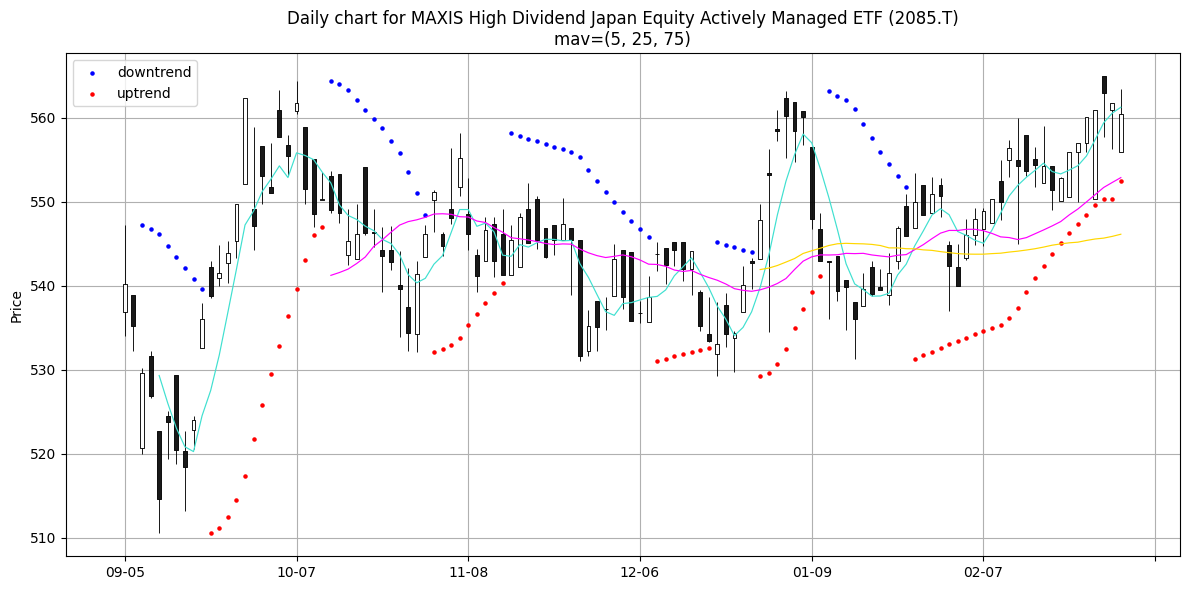

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-01-20 00:00:00+09:00    539.599976
2025-01-21 00:00:00+09:00    539.000000
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-01-20 00:00:00+09:00         NaN
2025-01-21 00:00:00+09:00   -0.599976
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-20 00:00:00+09:00    539.560010
2025-01-21 00:00:00+09:00    538.780005
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-20 00:00:00+09:00    543.879636
2025-01-21 00:00:00+09:00    543.686707
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-01-20 00:00:00+09:00    545.009139
2025-01-21 00:00:00+09:00    544.944295
Name: Close, dtype: float64